# Test hypothesis

## Import libraries

In [1]:
import os, sys, math
from operator import itemgetter

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
import statsmodels.api as sm

from tabulate import tabulate

sys.path.append(os.path.abspath(os.path.join('..', '..')))

## Configuration

### Participants meta

In [2]:
had_glasses = {
    'P2': False,
    'P3': True,
    'P4': False,
    'P5': False,
    'P6': False,
    'P7': False,
    'P8': False,
    'P9': True,
    'P10': False,
    'P11': False,
    'P12': False,
    'P13': False,
    'P14': False,
    'P15': True,
    'P16': False,
    'P17': False,
    'P18': True,
    'P19': False,
    'P20': False,
    'P21': True,
    'P22': False,
    'P23': True,
    'P24': False,
    'P25': False,
    'P26': True,
    'P27': False,
    'P28': False,
    'P29': False,
    'P30': False,
    'P31': False,
}

participants_with_glasses = []

for key, value in had_glasses.items():
    if value is True:
        participants_with_glasses.append(key)

gaze_truth = {
    'Top left': (162, 132),
    'Top center': (960, 132),
    'Top right': (1758, 132),
    'Middle left': (162, 540),
    'Middle center': (960, 540),
    'Middle right': (1758, 540),
    'Bottom left': (162, 948),
    'Bottom center': (960, 948),
    'Bottom right': (1758, 948),
}

# https://www.spectratech.gr/Web/Tobii/pdf/TX300.pdf
# https://onlinelibrary.wiley.com/doi/full/10.1111/infa.12441
# 51.1 × 28.7 cm // 23'' variant
# 52.7 × 29.6 cm // 24'' variant

screen_width_px = 1920
screen_width_mm = 511

screen_height_px = 1080
screen_height_mm = 287

## Functions

### Metrics calculations

In [3]:
def calculate_pixel_error(row, x_pred, y_pred):
    gaze_truth_point = gaze_truth[row['Stimul']]
    x = gaze_truth_point[0]
    y = gaze_truth_point[1]
    
    return np.sqrt(np.sum(np.square(np.array([x_pred - x, y_pred - y]))))


def calculate_on_screen_distance_error(row, x_pred, y_pred):
    gaze_truth_point = gaze_truth[row['Stimul']]
    x = gaze_truth_point[0]
    y = gaze_truth_point[1]
    
    x = (x / screen_width_px) * screen_width_mm
    x_pred = (x_pred / screen_width_px) * screen_width_mm

    y = (y / screen_height_px) * screen_height_mm
    y_pred = (y_pred / screen_height_px) * screen_height_mm

    return np.sqrt(np.sum(np.square(np.array([x_pred - x, y_pred - y]))))

def calculate_metrics(df):
    # Tobii
    df['Pixel_error_Tobii'] = df.apply(lambda row: calculate_pixel_error(row, row['Fixation_X'], row['Fixation_Y']), axis=1)
    df['On_screen_distance_Tobii'] = df.apply(lambda row: calculate_on_screen_distance_error(row, row['Fixation_X'], row['Fixation_Y']), axis=1)

    # RN18 SW Attention
    df['Pixel_error_Rage-Net'] = df.apply(lambda row: calculate_pixel_error(row, row['Rage-Net_X'], row['Rage-Net_Y']), axis=1)
    df['On_screen_distance_Rage-Net'] = df.apply(lambda row: calculate_on_screen_distance_error(row, row['Rage-Net_X'], row['Rage-Net_Y']), axis=1)

    return df
    
def drop_outliers(df):
    # Keep only rows, where Tobii OSD is lower than 50 mm
    df = df.loc[df['On_screen_distance_Tobii'] < 50, :]

    # Keep only rows, where CNN OSD is lower than 100 mm
    df = df.loc[df['On_screen_distance_Rage-Net'] < 100, :]
    
    return df

def aggregate_and_plt_osd_metric(df):
    table_header = ['Block', 'Rows', 'OSD - Tobii', 'OSD - Rage-Net']
    table_data = []

    for index in range(6):
        case_x = df.loc[df['Case'] == f'case_{index + 1}', ['On_screen_distance_Tobii', 'On_screen_distance_Rage-Net']]
        table_data.append([f'Block {index + 1}',
                           len(case_x),
                           case_x['On_screen_distance_Tobii'].mean(),
                           case_x['On_screen_distance_Rage-Net'].mean()])

    print(tabulate(table_data, headers=table_header, tablefmt="fancy_outline"))

def get_column_without_nulls(df_subset, column):
    return df_subset.loc[df_subset[column].notna()][column]

def column_to_cases(df_subset, column):
    df_subset_not_na = df_subset.loc[df_subset[column].notna()]
    return [df_subset_not_na.loc[df_subset_not_na['Case'] == f'case_{index + 1}'][column] for index in range(6)]        

def describe_data(df_subsets, subset_labels):
    table_data = []
    table_header = ['', 'Count', 'Mean', 'STD', 'Min', '25%', '50%', '75%', 'Max', 'Skewness', 'Curtosis']

    for index, subset in enumerate(df_subsets):
        table_data.append([subset_labels[index]] + subset.describe().to_list() + [subset.skew(), subset.kurtosis()])

    print(tabulate(table_data, headers=table_header, tablefmt="fancy_outline"))

### Plotting functions

In [4]:
def plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, title, bar_ylim=None, box_ylim=None, use_violin_plot=False, file=None, figsize=(10, 5),
                                              use_both_plots=False):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(1, 2 if not use_both_plots else 3, figsize=figsize)
    axes = axes.ravel()
    
    if bar_ylim:
        axes[0].set_ylim(*bar_ylim)
    
    if box_ylim:
        axes[1].set_ylim(*box_ylim)
        
    sns.barplot(data=df_subsets, capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"), ax=axes[0])
    
    if use_both_plots:
        sns.boxplot(data=df_subsets, flierprops={"marker": "x"}, palette='Blues', medianprops={"color": "black"}, ax=axes[1])
        sns.violinplot(data=df_subsets, palette='Blues', ax=axes[2])
    elif not use_violin_plot:
        sns.boxplot(data=df_subsets, flierprops={"marker": "x"}, palette='Blues', medianprops={"color": "black"}, ax=axes[1])
    else:
        sns.violinplot(data=df_subsets, palette='Blues', ax=axes[1])
    
    axes[0].set_ylabel('OSD (mm)')
    axes[1].set_ylabel('OSD (mm)')

    axes[0].set_xticklabels(subset_labels, fontsize=10)
    axes[1].set_xticklabels(subset_labels, fontsize=10)
    if use_both_plots:
        axes[2].set_ylabel('OSD (mm)')
        axes[2].set_xticklabels(subset_labels, fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.suptitle(title)
    fig.tight_layout()
    
    if file:
        plt.savefig(file)
    plt.show()

def plot_distributions(df, columns):
    sns.reset_defaults()

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes = axes.ravel() # 2D to 1D list

    for column, ax in zip(columns, axes):
        sns.histplot(data=df[column], kde=True, ax=ax)

    plt.suptitle("Data distributions for Tobii and Rage-Net (OSD)", fontsize=10)
    fig.tight_layout()
    plt.show()
    
    
def plot_distributions_from_columns(df_subsets, title, file=None, fontsize=10, ax_0_lim=(0, 50), ax_1_lim=None, figsize=(10, 3)):
    sns.reset_defaults()

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = axes.ravel()

    if ax_0_lim:
        axes[0].set_xlim(*ax_0_lim)
        # axes[0].set_ylim(0, 300)
    if ax_1_lim:
        axes[1].set_xlim(*ax_1_lim)
        # axes[1].set_ylim(0, 300)

    sns.histplot(data=df_subsets[0], kde=True, ax=axes[0])
    sns.histplot(data=df_subsets[1], kde=True, ax=axes[1])

    plt.suptitle(title, fontsize=fontsize)
    fig.tight_layout()
    if file:
        plt.savefig(file)
    plt.show()

    
def plot_dist_violin(df, columns):
    sns.set_style('whitegrid')

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes = axes.ravel() # 2D to 1D list

    for column, ax in zip(columns, axes):
        sns.violinplot(data=df, x=column, y='Case', palette='Blues', ax=ax)

    plt.suptitle("Data distributions aggregated over tested blocks for Tobii and Rage-Net (OSD)")
    fig.tight_layout()
    plt.show()

def plot_central_tendencies(df, columns):
    sns.set_style('whitegrid')

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes = axes.ravel() # 2D to 1D list

    for column, ax in zip(columns, axes):
        sns.barplot(x='Case', y=column, data=df, 
                capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"), ax=ax)

    plt.suptitle("Central tendencies for Tobii and Rage-Net (OSD)")
    plt.show()
    
def plot_quantiles(df, x, y, color_palette):
    # https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
    plt.figure(figsize=(14, 8))
    sns.set_style('whitegrid')
    sns.boxplot(x=x, y=y, data=df, flierprops={"marker": "x"}, palette=color_palette, medianprops={"color": "black"})
    plt.title(f'Quartiles {x} by participants')
    plt.show()

### Statistical functions

In [5]:
def kruskal_wallis_h_test(df_subsets, alpha):
    stat, p_value = kruskal(*df_subsets)
    print(f'Statistics = {stat:.3f} |  p-value = {p_value:.5f}', end='\n\n')

    # Interpret
    if p_value > alpha:
        print('Same probability distribution (fail to reject H0)')
    else:
        print('Different probability distribution (reject H0)')

def test_normality_of_distribution(df_subsets, labels, alpha, title_font=11, figsize=(8, 3)):
    table_header = ['', 'Statistics', 'P-value', 'Result']
    table_data = []

    if (len(df_subsets) % 3) == 0:
        fig, axes = plt.subplots(math.ceil(len(df_subsets) / 3), 3, figsize=figsize)
    else:
        fig, axes = plt.subplots(math.ceil(len(df_subsets) / 2), 2, figsize=figsize)
    axes = axes.ravel() # 2D to 1D list

    for df_subset, label, ax in zip(df_subsets, labels, axes):
        ax.set_title(label, fontsize=title_font)
        shapiro_result = stats.shapiro(df_subset)
        
        distribution = 'Normal distribution' if shapiro_result.pvalue > alpha else 'Not normal distribution'
        table_data.append([label, shapiro_result.statistic, shapiro_result.pvalue, distribution])
        
        _ = sm.ProbPlot(df_subset, fit=True).qqplot(line='45', ax=ax)
        ax.set_xlabel('Theoretical quantiles')
        ax.set_ylabel('Sample quantiles')
    
    print(tabulate(table_data, headers=table_header), end='\n\n')
    
    fig.tight_layout()
    plt.show()
    
def mann_whitney_u_test(df_subsets, labels, alpha, alternative='two-sided'):
    df_subsets = df_subsets.copy()
    table_data = [[labels[0], '-', '-', '-']]
    table_header = ['', 'Statistics', 'P-value', 'Z-score', 'Hypothesis', 'N_x', 'N_y', 'R-score']
    base_subset = df_subsets.pop(0)

    for df_subset, label in zip(df_subsets, labels[1:]):
        # Run mann whitney u test
        U1, p_value = mannwhitneyu(base_subset, df_subset, alternative=alternative)
        
        # Compute Z-score
        # @see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#r31b0b1c0fec3-4
        # @see https://pressbooks.library.upei.ca/montelpare/chapter/computing-the-wilcoxon-mann-whitney-2-group-comparison-test/
        # @see https://ezspss.com/how-to-report-a-mann-whitney-u-test-from-spss-in-apa-style/
        nx = len(base_subset)
        ny = len(df_subset)
        U2 = nx*ny - U1
        U = min(U1, U2)
        N = nx + ny
        continuity_correction = 0 # 0.5
        
        z_score = (U - nx*ny/2 + continuity_correction) / np.sqrt(nx*ny * (N + 1)/ 12)
        r_score = abs(z_score/np.sqrt(N))
        
        
        result = None
              
        # Interpret p-value
        if p_value > alpha:
            result = 'Fail to reject H0'
        else:
            result = 'Reject H0'
        
        table_data.append([label, U1, p_value, z_score, result, nx, ny, r_score])
        
    print(tabulate(table_data, headers=table_header, tablefmt="fancy_grid"))

def mann_whitney_u_test_each_with_each(df_subsets, labels, alpha):
    table_data = []
    table_header = labels

    for index_1, df_subset_1, label in zip(range(len(df_subsets)), df_subsets, labels):
        data_row = []
        data_row.append(label)
        
        for index_2, df_subset_2 in enumerate(df_subsets):
            if index_1 == index_2:
                data_row.append('-')
                continue
            
            # Run mann whitney u test
            stat, p_value = mannwhitneyu(df_subset_1, df_subset_2) 
            result = None

            # Interpret
            if p_value > alpha:
                result = 'Fail to reject H0' # Same dist.
            else:
                result = 'Reject H0' # Different dist.
            
            data_row.append(result)

        table_data.append(data_row)
        
    print(tabulate(table_data, headers=table_header, tablefmt="fancy_outline"))
    
def aggregate_column_by_case(df, column):
    df_cases = []
    labels = []
    for case in df['Case'].unique():
        df_cases.append(df.loc[df['Case'] == case, :][column])
        labels.append(case.title())
    
    return df_cases, labels

def describe_dataframe(df_subset, grouped=False):
    stats = df_subset.describe()
    
    if grouped is True:
        stats = stats.transpose()
        stats.loc['skewness'] = df_subset.apply(pd.DataFrame.skew)
        stats.loc['kurtosis'] = df_subset.apply(pd.DataFrame.kurt)
    else:
        stats.loc['skewness'] = df_subset.skew().tolist()
        stats.loc['kurtosis'] = df_subset.kurtosis().tolist()
    return stats.transpose()

def make_label_first(df_cases, labels, target_label):
    target_index = labels.index(target_label)
    df_cases.insert(0, df_cases.pop(target_index))
    labels.insert(0, labels.pop(target_index))
    
    return df_cases, labels

## Test hypothesis

### Load data to dataframe

In [6]:
data_directory = '../../Datasets/Study_2/Meta.tsv'
df = pd.read_csv(data_directory, header=0, delimiter='\t')

# Calculate metrics
df = calculate_metrics(df)

# Split to with and without glasses
df_with_glasses = df.loc[df['Participant'].isin(participants_with_glasses), :]
df_no_glasses = df.loc[~df['Participant'].isin(participants_with_glasses), :]

# Hypothesis 1
## The error of both gaze prediction approaches will be worse for participants who took part in the study with glasses.

To test the hypothesis, we will use a significance level of **$\alpha$ = 0.05** for verifying the normal distribution.

- **H0:** The medians of On_screen_distance_Tobii and On_screen_distance_Rage-Net are the same (<=) for participants with glasses as for those without glasses.
  - with glasses = without glasses (<=)
- **H1:** The medians of On_screen_distance_Tobii and On_screen_distance_Rage-Net are higher for participants with glasses.
  - with glasses > without glasses (alternative=greater)

**Result:**
- The data distribution is not normal (p-value is less than the alpha level of 0.05), so we will use the **Mann Whitney U test**.
- P-value < 0.05 -> **Reject H0** for both Tobii OSD and Rage-Net OSD.
  - The alternative hypothesis H1 holds.

In [7]:
df_subsets = [get_column_without_nulls(df_with_glasses, 'On_screen_distance_Tobii'),
              get_column_without_nulls(df_no_glasses, 'On_screen_distance_Tobii'),
              df_with_glasses['On_screen_distance_Rage-Net'],
              df_no_glasses['On_screen_distance_Rage-Net']]
subset_labels =  ['Tobii OSD (with glasses)', 'Tobii OSD (without glasses)', 
                  'Rage-Net OSD (with glasses)', 'Rage-Net OSD (without glasses)']

describe_data(df_subsets, subset_labels)

╒════════════════════════════════╤═════════╤══════════╤═════════╤══════════╤══════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                                │   Count │     Mean │     STD │      Min │      25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════════════════╪═════════╪══════════╪═════════╪══════════╪══════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Tobii OSD (with glasses)       │     995 │  20.4138 │ 40.8034 │ 0.532292 │  6.32178 │ 10.4242  │  15.4912 │ 354.673 │    4.56365 │  22.6196   │
│ Tobii OSD (without glasses)    │    3493 │  12.4881 │ 24.5444 │ 0        │  5.30219 │  8.65234 │  13.0647 │ 446.777 │    9.49876 │ 108.575    │
│ Rage-Net OSD (with glasses)    │    1134 │ 122.779  │ 93.241  │ 3.26191  │ 52.4174  │ 96.5112  │ 172.052  │ 443.785 │    1.19598 │   1.05549  │
│ Rage-Net OSD (without glasses) │    3726 │  97.3605 │ 85.184  │ 1.06801  │ 34.5731  │ 63.386   │ 133.331  │ 466.863 │    1

                                  Statistics      P-value  Result
------------------------------  ------------  -----------  -----------------------
Tobii OSD (with glasses)            0.382571  0            Not normal distribution
Tobii OSD (without glasses)         0.27028   0            Not normal distribution
Rage-Net OSD (with glasses)         0.890633  1.33625e-27  Not normal distribution
Rage-Net OSD (without glasses)      0.829161  0            Not normal distribution



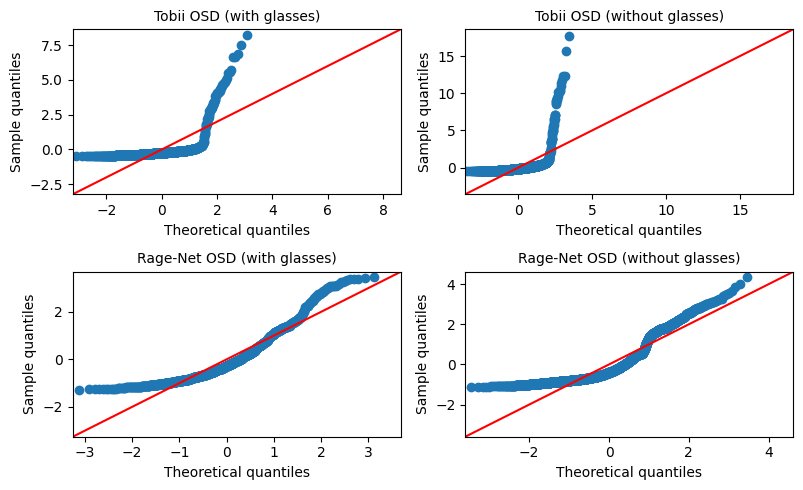

In [8]:
test_normality_of_distribution(df_subsets, subset_labels, 0.05, figsize=(8, 5), title_font=10)

In [9]:
mann_whitney_u_test(df_subsets[:2], subset_labels[:2], 0.05, alternative='greater')
mann_whitney_u_test(df_subsets[2:], subset_labels[2:], 0.05, alternative='greater')

╒═════════════════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                             │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii OSD (with glasses)    │ -            │ -                     │ -                  │              │       │       │           │
├─────────────────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii OSD (without glasses) │ 2007169.5    │ 3.965735086397076e-14 │ -7.471465624879323 │ Reject H0    │   995 │  3493 │  0.111527 │
╘═════════════════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛
╒════════════════════════════════╤══════════════╤══════

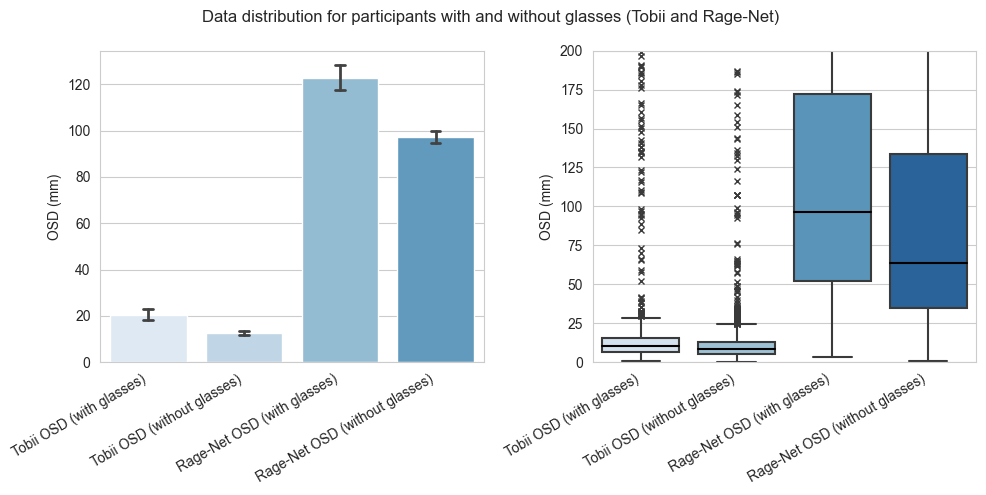

In [10]:
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for participants with and without glasses (Tobii and Rage-Net)',
                                           box_ylim=(0, 200))

In [11]:
describe_data(df_subsets, subset_labels)

╒════════════════════════════════╤═════════╤══════════╤═════════╤══════════╤══════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                                │   Count │     Mean │     STD │      Min │      25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════════════════╪═════════╪══════════╪═════════╪══════════╪══════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Tobii OSD (with glasses)       │     995 │  20.4138 │ 40.8034 │ 0.532292 │  6.32178 │ 10.4242  │  15.4912 │ 354.673 │    4.56365 │  22.6196   │
│ Tobii OSD (without glasses)    │    3493 │  12.4881 │ 24.5444 │ 0        │  5.30219 │  8.65234 │  13.0647 │ 446.777 │    9.49876 │ 108.575    │
│ Rage-Net OSD (with glasses)    │    1134 │ 122.779  │ 93.241  │ 3.26191  │ 52.4174  │ 96.5112  │ 172.052  │ 443.785 │    1.19598 │   1.05549  │
│ Rage-Net OSD (without glasses) │    3726 │  97.3605 │ 85.184  │ 1.06801  │ 34.5731  │ 63.386   │ 133.331  │ 466.863 │    1

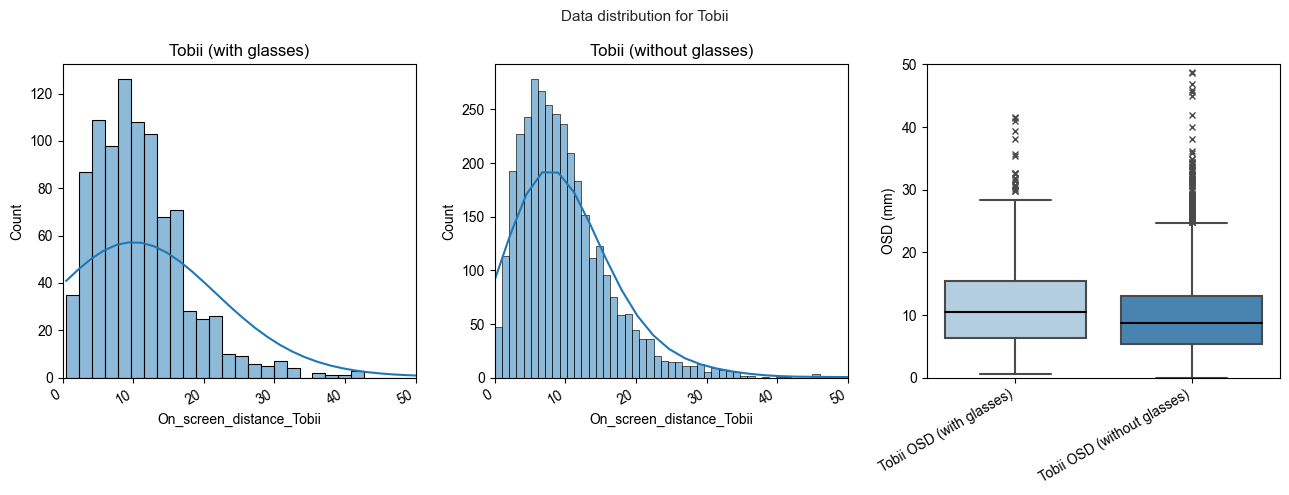

In [12]:
sns.reset_defaults()

fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes = axes.ravel()

axes[0].set_xlim(0, 50)
axes[0].set_title('Tobii (with glasses)')
axes[1].set_xlim(0, 50)
axes[1].set_title('Tobii (without glasses)')
axes[2].set_ylim(0, 50)

sns.histplot(data=df_subsets[0], kde=True, ax=axes[0])
sns.histplot(data=df_subsets[1], kde=True, ax=axes[1])
sns.set_style('whitegrid')
sns.set_style('whitegrid')
sns.boxplot(data=df_subsets[:2], flierprops={"marker": "x"}, palette='Blues', medianprops={"color": "black"}, ax=axes[2])

axes[2].set_ylabel('OSD (mm)')
axes[2].set_xticklabels(subset_labels[:2], fontsize=10)
plt.gcf().autofmt_xdate()

plt.suptitle('Data distribution for Tobii', fontsize=11)
fig.tight_layout()
plt.show()

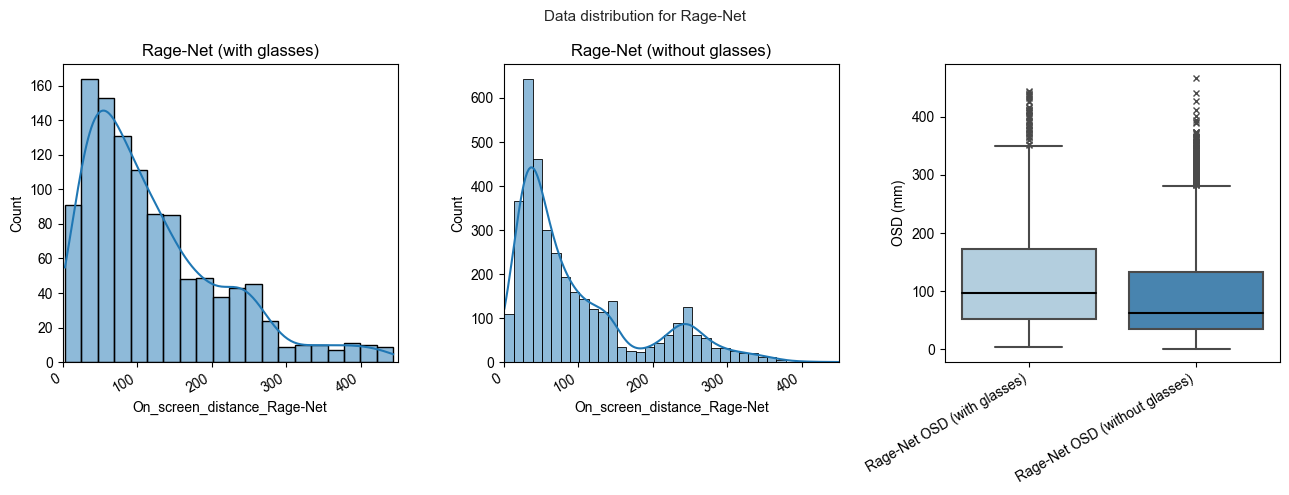

In [13]:
sns.reset_defaults()

fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes = axes.ravel()

axes[0].set_xlim(0, 450)
axes[0].set_title('Rage-Net (with glasses)')
axes[1].set_xlim(0, 450)
axes[1].set_title('Rage-Net (without glasses)')

sns.histplot(data=df_subsets[2], kde=True, ax=axes[0])
sns.histplot(data=df_subsets[3], kde=True, ax=axes[1])
sns.set_style('whitegrid')
sns.boxplot(data=df_subsets[2:], flierprops={"marker": "x"}, palette='Blues', medianprops={"color": "black"}, ax=axes[2])

axes[2].set_ylabel('OSD (mm)')
axes[2].set_xticklabels(subset_labels[2:], fontsize=10)
plt.gcf().autofmt_xdate()

plt.suptitle('Data distribution for Rage-Net', fontsize=11)
fig.tight_layout()
plt.show()

# Hypothesis 2 (Tobii without glasses)
## Increasing the distance will have a negative impact on the Tobii eye-tracker error.

To test the hypothesis, we will use a significance level of **$\alpha$ = 0.05** for verifying the normal distribution.

- **H0:** The medians of On_screen_distance_Tobii for Case 1 and Case 2 are the same (>=)
  - case_1 = case_2 (>=)
- **H1:** The median for Case 1 is lower than for Case 2 for On_screen_distance_Tobii
  - case_1 < case_2 (alternative=less)

**Result:**
- The data distribution is not normal (p-value is less than the alpha level of 0.05), so we will use the **Mann Whitney U test**.
- P-value < 0.05 -> **Reject H0**
  - H1 holds.

In [14]:
df_subsets = column_to_cases(df_no_glasses, 'On_screen_distance_Tobii')
subset_labels =  [f'Tobii OSD (block {index + 1})' for index in range(6)]

describe_data(df_subsets, subset_labels)

╒═════════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                     │   Count │    Mean │     STD │      Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii OSD (block 1) │     619 │ 11.7178 │ 25.3537 │ 0.265741 │ 4.67925 │ 8.0848  │ 11.6594 │ 292.105 │    8.54037 │    79.6181 │
│ Tobii OSD (block 2) │     436 │ 14.4072 │ 23.295  │ 0.594939 │ 5.61306 │ 9.95522 │ 15.9676 │ 248.579 │    7.32771 │    64.0534 │
│ Tobii OSD (block 3) │     614 │ 13.3513 │ 29.4251 │ 0        │ 5.26891 │ 8.39828 │ 12.5295 │ 314.757 │    7.663   │    63.8036 │
│ Tobii OSD (block 4) │     604 │ 12.1241 │ 27.9742 │ 0.266146 │ 5.56174 │ 8.78021 │ 12.7747 │ 446.777 │   12.0925  │   165.051  │
│ Tobii OSD (block 5) │     607 │ 11.8616 │ 20.7402 │ 0.797222 │ 5.19425 │ 8.28333 

In [15]:
aggregate_and_plt_osd_metric(df_no_glasses)

╒═════════╤════════╤═══════════════╤══════════════════╕
│ Block   │   Rows │   OSD - Tobii │   OSD - Rage-Net │
╞═════════╪════════╪═══════════════╪══════════════════╡
│ Block 1 │    621 │       11.7178 │          51.5259 │
│ Block 2 │    621 │       14.4072 │          55.6164 │
│ Block 3 │    621 │       13.3513 │         140.791  │
│ Block 4 │    621 │       12.1241 │         212.795  │
│ Block 5 │    621 │       11.8616 │          59.1132 │
│ Block 6 │    621 │       12.0152 │          64.3214 │
╘═════════╧════════╧═══════════════╧══════════════════╛


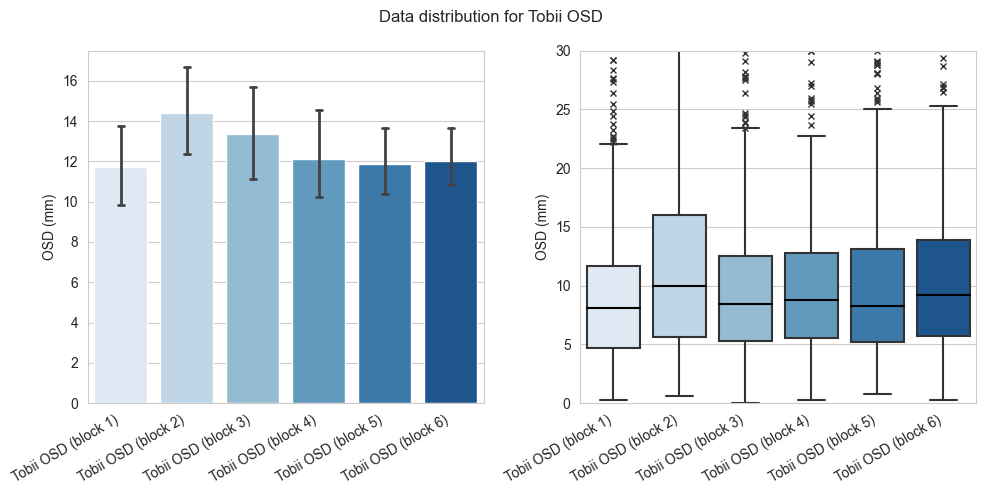

In [16]:
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii OSD', box_ylim=(0, 30))

                       Statistics      P-value  Result
-------------------  ------------  -----------  -----------------------
Tobii OSD (block 1)      0.249681  3.64338e-44  Not normal distribution
Tobii OSD (block 2)      0.375452  4.75809e-36  Not normal distribution



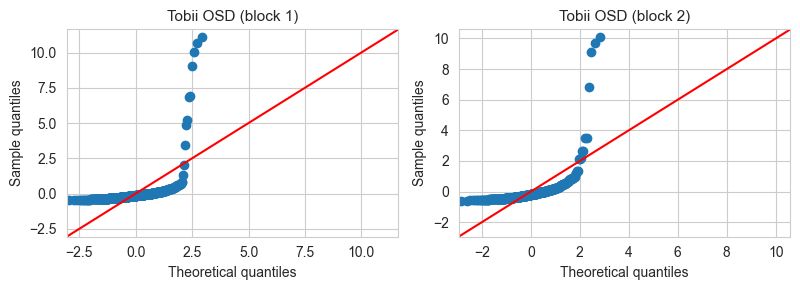

In [17]:
test_normality_of_distribution(df_subsets[:2], subset_labels[:2], 0.05, figsize=(8, 3), title_font=11)

In [18]:
mann_whitney_u_test(df_subsets[:2], subset_labels[:2], 0.05, alternative='less')

╒═════════════════════╤══════════════╤════════════════════════╤═══════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                     │ Statistics   │ P-value                │ Z-score           │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════════╪══════════════╪════════════════════════╪═══════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii OSD (block 1) │ -            │ -                      │ -                 │              │       │       │           │
├─────────────────────┼──────────────┼────────────────────────┼───────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii OSD (block 2) │ 110333.5     │ 2.2150957147794404e-07 │ -5.04957976734995 │ Reject H0    │   619 │   436 │  0.155464 │
╘═════════════════════╧══════════════╧════════════════════════╧═══════════════════╧══════════════╧═══════╧═══════╧═══════════╛


## Hypothesis 2 (Tobii with glasses)

                       Statistics      P-value  Result
-------------------  ------------  -----------  -----------------------
Tobii OSD (block 1)      0.3899    1.02735e-24  Not normal distribution
Tobii OSD (block 2)      0.629344  2.75981e-12  Not normal distribution



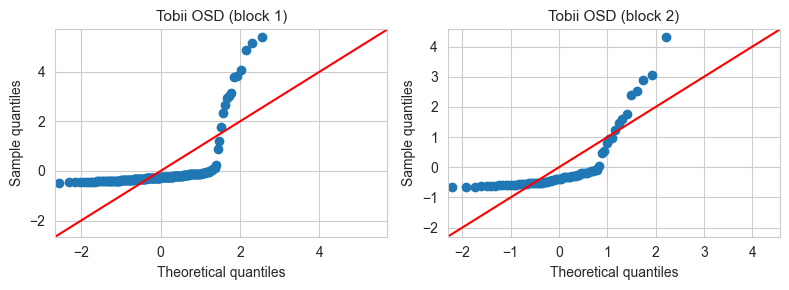

╒═════════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                     │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii OSD (block 1) │ -            │ -                     │ -                  │              │       │       │           │
├─────────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii OSD (block 2) │ 4956.0       │ 0.0003643468830999431 │ -3.379469348874513 │ Reject H0    │   186 │    73 │   0.20999 │
╘═════════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [19]:
df_subsets = column_to_cases(df_with_glasses, 'On_screen_distance_Tobii')
test_normality_of_distribution(df_subsets[:2], subset_labels[:2], 0.05, figsize=(8, 3), title_font=11)
mann_whitney_u_test(df_subsets[:2], subset_labels[:2], 0.05, alternative='less')

## Hypothesis 2 (Tobii with glasses and without glasses)

                       Statistics      P-value  Result
-------------------  ------------  -----------  -----------------------
Tobii OSD (block 1)      0.288147  0            Not normal distribution
Tobii OSD (block 2)      0.40686   1.06685e-37  Not normal distribution



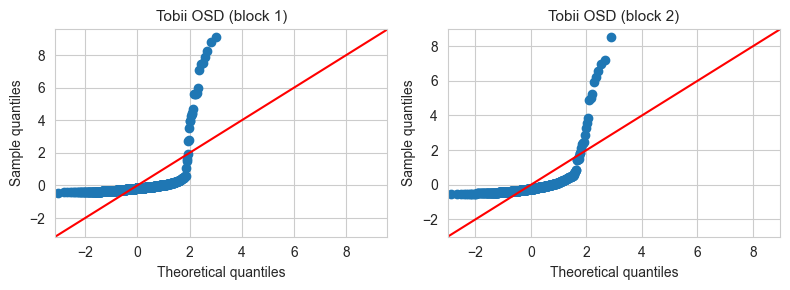

╒═════════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                     │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii OSD (block 1) │ -            │ -                     │ -                  │              │       │       │           │
├─────────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii OSD (block 2) │ 168521.5     │ 2.901456577102735e-08 │ -5.424844299725119 │ Reject H0    │   805 │   509 │  0.149654 │
╘═════════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [20]:
df_subsets = column_to_cases(df, 'On_screen_distance_Tobii')
test_normality_of_distribution(df_subsets[:2], subset_labels[:2], 0.05, figsize=(8, 3), title_font=11)
mann_whitney_u_test(df_subsets[:2], subset_labels[:2], 0.05, alternative='less')

## Hypothesis 2 (Rage-Net without glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     621 │ 51.5259 │ 38.1022 │ 1.06801 │ 28.1902 │ 41.2886 │ 67.3515 │ 351.209 │    2.58371 │   12.0349  │
│ Rage-Net (block 2) │     621 │ 55.6164 │ 42.0929 │ 2.39449 │ 27.4461 │ 43.4216 │ 74.9638 │ 294.63  │    2.20109 │    7.23803 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


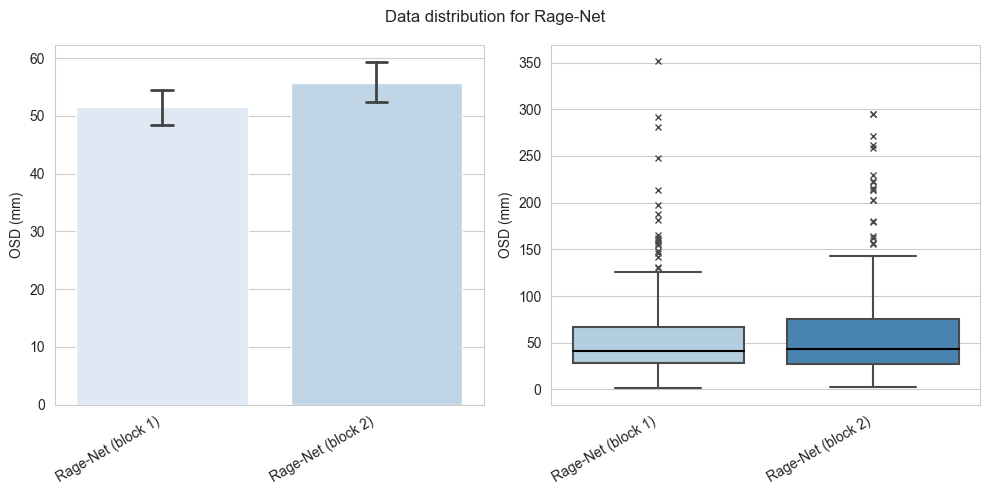

                      Statistics      P-value  Result
------------------  ------------  -----------  -----------------------
Rage-Net (block 1)      0.802341  7.69701e-27  Not normal distribution
Rage-Net (block 2)      0.811903  2.78795e-26  Not normal distribution



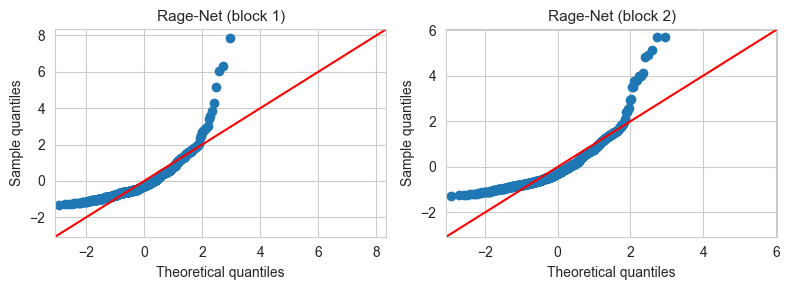

╒════════════════════╤══════════════╤════════════════════╤═════════════════════╤═══════════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value            │ Z-score             │ Hypothesis        │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪════════════════════╪═════════════════════╪═══════════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                  │ -                   │                   │       │       │           │
├────────────────────┼──────────────┼────────────────────┼─────────────────────┼───────────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 2) │ 184122.0     │ 0.0843792194494401 │ -1.3762832562926217 │ Fail to reject H0 │   621 │   621 │ 0.0390523 │
╘════════════════════╧══════════════╧════════════════════╧═════════════════════╧═══════════════════╧═══════╧═══════╧═══════════╛


In [21]:
df_subsets = list(itemgetter(0, 1)(column_to_cases(df_no_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(2)]
                  
describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')
test_normality_of_distribution(df_subsets, subset_labels, 0.05, figsize=(8, 3), title_font=11)
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 2 (Rage-Net with glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     189 │ 72.056  │ 48.9292 │ 6.83559 │ 41.7775 │ 66.4377 │  91.8954 │ 394.55  │    2.42468 │   10.9102  │
│ Rage-Net (block 2) │     189 │ 77.7448 │ 56.681  │ 3.26191 │ 40.1879 │ 62.0771 │ 104.582  │ 364.794 │    1.68486 │    4.15053 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════╧═════════╧════════════╧════════════╛


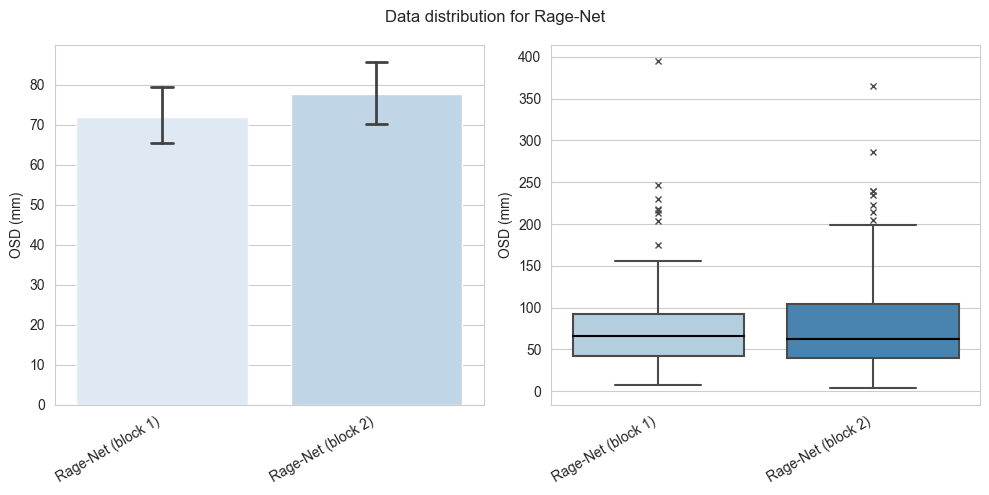

                      Statistics      P-value  Result
------------------  ------------  -----------  -----------------------
Rage-Net (block 1)       0.82307  6.9794e-14   Not normal distribution
Rage-Net (block 2)       0.86972  1.08188e-11  Not normal distribution



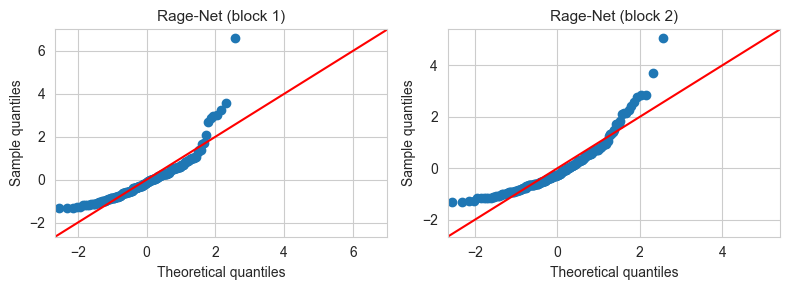

╒════════════════════╤══════════════╤═══════════════════╤═════════════════════╤═══════════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value           │ Z-score             │ Hypothesis        │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════╪═════════════════════╪═══════════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                 │ -                   │                   │       │       │           │
├────────────────────┼──────────────┼───────────────────┼─────────────────────┼───────────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 2) │ 17409.0      │ 0.335562091431604 │ -0.4250763752000919 │ Fail to reject H0 │   189 │   189 │ 0.0218636 │
╘════════════════════╧══════════════╧═══════════════════╧═════════════════════╧═══════════════════╧═══════╧═══════╧═══════════╛


In [22]:
df_subsets = list(itemgetter(0, 1)(column_to_cases(df_with_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(2)]
                  
describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')
test_normality_of_distribution(df_subsets, subset_labels, 0.05, figsize=(8, 3), title_font=11)
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 2 (Rage-Net with glasses and without glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     810 │ 56.3163 │ 41.7666 │ 1.06801 │ 29.098  │ 45.3018 │ 72.7244 │ 394.55  │    2.55354 │   11.9186  │
│ Rage-Net (block 2) │     810 │ 60.7797 │ 46.8207 │ 2.39449 │ 28.6294 │ 48.0206 │ 81.3906 │ 364.794 │    2.08962 │    6.39699 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


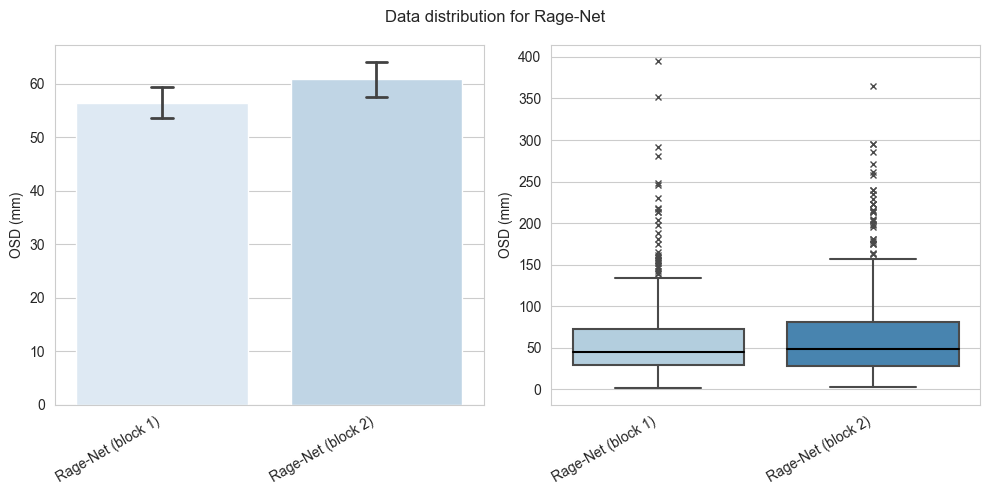

                      Statistics      P-value  Result
------------------  ------------  -----------  -----------------------
Rage-Net (block 1)      0.807524  5.83298e-30  Not normal distribution
Rage-Net (block 2)      0.821467  4.70212e-29  Not normal distribution



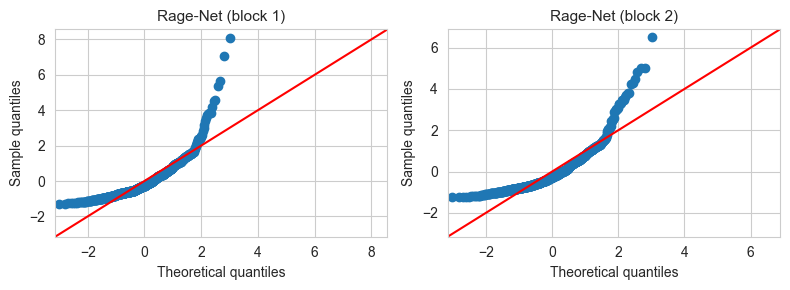

╒════════════════════╤══════════════╤════════════════════╤═════════════════════╤═══════════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value            │ Z-score             │ Hypothesis        │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪════════════════════╪═════════════════════╪═══════════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                  │ -                   │                   │       │       │           │
├────────────────────┼──────────────┼────────────────────┼─────────────────────┼───────────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 2) │ 315692.0     │ 0.0946526100952314 │ -1.3126903348268208 │ Fail to reject H0 │   810 │   810 │ 0.0326141 │
╘════════════════════╧══════════════╧════════════════════╧═════════════════════╧═══════════════════╧═══════╧═══════╧═══════════╛


In [23]:
df_subsets = list(itemgetter(0, 1)(column_to_cases(df, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(2)]
                  
describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')
test_normality_of_distribution(df_subsets, subset_labels, 0.05, figsize=(8, 3), title_font=11)
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 3 (Camera position: center-down, Rage-Net without glasses)

╒════════════════════╤═════════╤══════════╤═════════╤═════════╤═════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │     Mean │     STD │     Min │     25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪══════════╪═════════╪═════════╪═════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     621 │  51.5259 │ 38.1022 │ 1.06801 │ 28.1902 │  41.2886 │  67.3515 │ 351.209 │  2.58371   │   12.0349  │
│ Rage-Net (block 3) │     621 │ 140.791  │ 80.8596 │ 4.01342 │ 57.238  │ 140.094  │ 231.122  │ 374.581 │  0.0551523 │   -1.22362 │
╘════════════════════╧═════════╧══════════╧═════════╧═════════╧═════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


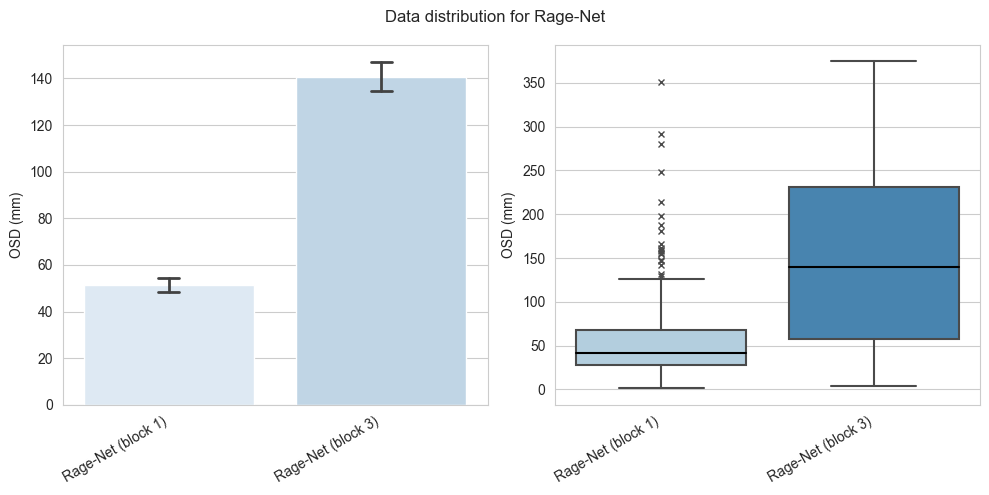

╒════════════════════╤══════════════╤═══════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                   │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 3) │ 69007.0      │ 9.449033037233474e-86 │ -19.589865718570618 │ Reject H0    │   621 │   621 │  0.555867 │
╘════════════════════╧══════════════╧═══════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [24]:
df_subsets = list(itemgetter(0, 2, 3)(column_to_cases(df_no_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 2, 3)(subset_labels))

df_subsets = list(itemgetter(0, 1)(df_subsets))
subset_labels = list(itemgetter(0, 1)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 3 (Camera position: center-down, Rage-Net with glasses)

╒════════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │      Min │     25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     189 │  72.056 │ 48.9292 │  6.83559 │ 41.7775 │  66.4377 │  91.8954 │ 394.55  │  2.42468   │    10.9102 │
│ Rage-Net (block 3) │     189 │ 144.052 │ 81.8174 │ 11.2115  │ 65.4933 │ 140.979  │ 229.803  │ 332.418 │  0.0016597 │    -1.2012 │
╘════════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


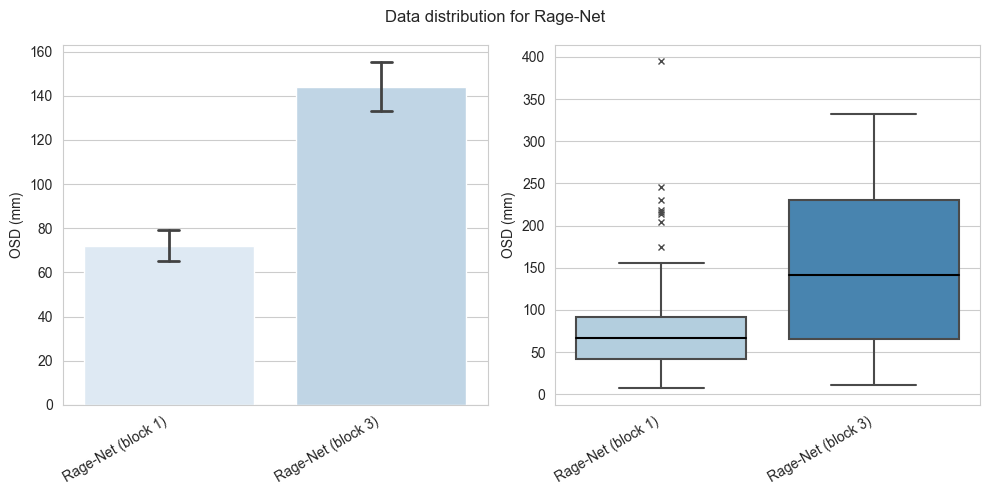

╒════════════════════╤══════════════╤═══════════════════════╤═══════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score           │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪═══════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                 │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼───────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 3) │ 8753.0       │ 4.996653223582037e-18 │ -8.57449188734183 │ Reject H0    │   189 │   189 │  0.441024 │
╘════════════════════╧══════════════╧═══════════════════════╧═══════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [25]:
df_subsets = list(itemgetter(0, 2, 3)(column_to_cases(df_with_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 2, 3)(subset_labels))

df_subsets = list(itemgetter(0, 1)(df_subsets))
subset_labels = list(itemgetter(0, 1)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 3 (Camera position: center-down, Rage-Net with glasses and without glasses)

╒════════════════════╤═════════╤══════════╤═════════╤═════════╤═════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │     Mean │     STD │     Min │     25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪══════════╪═════════╪═════════╪═════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     810 │  56.3163 │ 41.7666 │ 1.06801 │ 29.098  │  45.3018 │  72.7244 │ 394.55  │  2.55354   │   11.9186  │
│ Rage-Net (block 3) │     810 │ 141.552  │ 81.0451 │ 4.01342 │ 58.7433 │ 140.528  │ 229.963  │ 374.581 │  0.0427782 │   -1.21888 │
╘════════════════════╧═════════╧══════════╧═════════╧═════════╧═════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


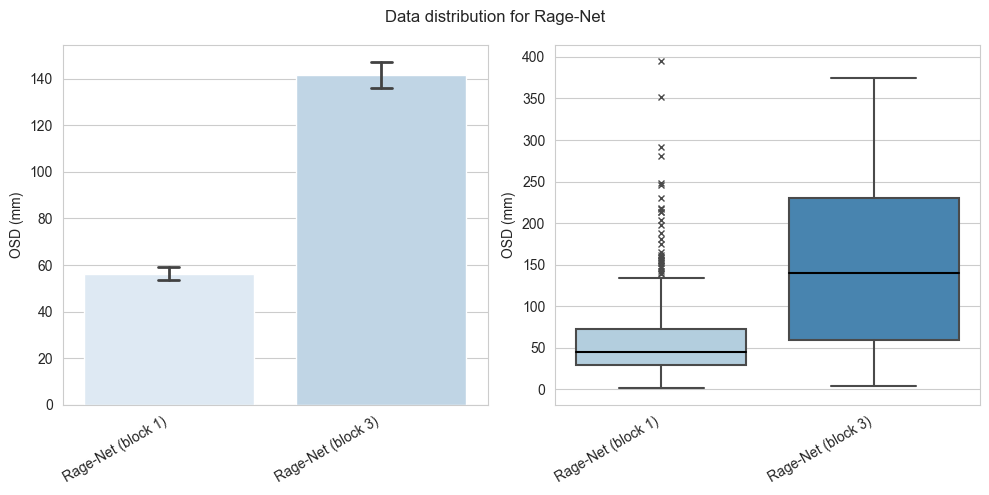

╒════════════════════╤══════════════╤════════════════════════╤═══════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value                │ Z-score           │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪════════════════════════╪═══════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                      │ -                 │              │       │       │           │
├────────────────────┼──────────────┼────────────────────────┼───────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 3) │ 128623.0     │ 6.784059965044212e-100 │ -21.1835163783386 │ Reject H0    │   810 │   810 │  0.526309 │
╘════════════════════╧══════════════╧════════════════════════╧═══════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [26]:
df_subsets = list(itemgetter(0, 2, 3)(column_to_cases(df, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 2, 3)(subset_labels))

df_subsets = list(itemgetter(0, 1)(df_subsets))
subset_labels = list(itemgetter(0, 1)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 4 (Camera position: left, Rage-Net without glasses)

╒════════════════════╤═════════╤══════════╤═════════╤═════════╤══════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │     Mean │     STD │     Min │      25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪══════════╪═════════╪═════════╪══════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     621 │  51.5259 │ 38.1022 │ 1.06801 │  28.1902 │  41.2886 │  67.3515 │ 351.209 │   2.58371  │  12.0349   │
│ Rage-Net (block 4) │     621 │ 212.795  │ 96.642  │ 8.41628 │ 138.502  │ 232.429  │ 280.153  │ 466.863 │  -0.420346 │  -0.679597 │
╘════════════════════╧═════════╧══════════╧═════════╧═════════╧══════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


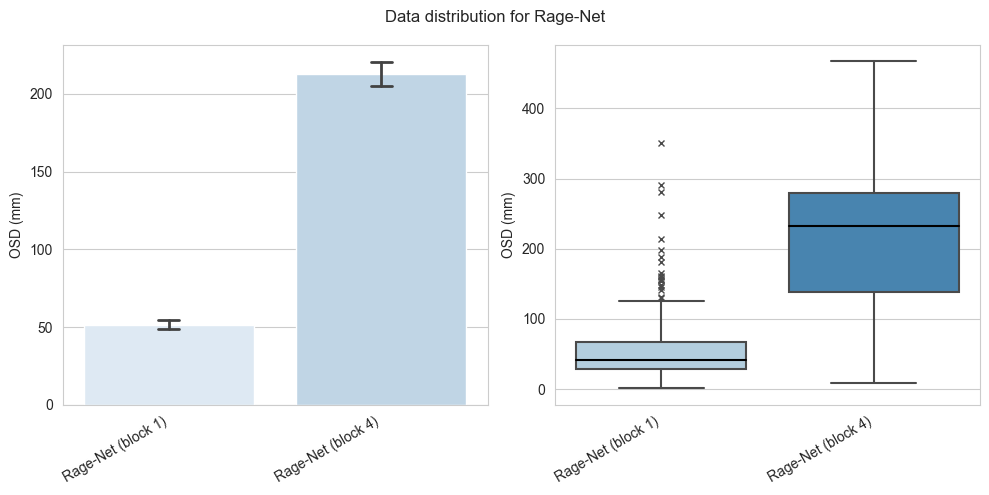

╒════════════════════╤══════════════╤═════════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value                 │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═════════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                       │ -                   │              │       │       │           │
├────────────────────┼──────────────┼─────────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 4) │ 32480.0      │ 2.7649866877115186e-142 │ -25.369195315926554 │ Reject H0    │   621 │   621 │  0.719856 │
╘════════════════════╧══════════════╧═════════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [27]:
df_subsets = list(itemgetter(0, 2, 3)(column_to_cases(df_no_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 2, 3)(subset_labels))

df_subsets = list(itemgetter(0, 2)(df_subsets))
subset_labels = list(itemgetter(0, 2)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 4 (Camera position: left, Rage-Net with glasses)

╒════════════════════╤═════════╤═════════╤══════════╤═════════╤══════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │      STD │     Min │      25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪══════════╪═════════╪══════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     189 │  72.056 │  48.9292 │ 6.83559 │  41.7775 │  66.4377 │  91.8954 │ 394.55  │   2.42468  │   10.9102  │
│ Rage-Net (block 4) │     189 │ 209.192 │ 104.37   │ 8.17915 │ 134.32   │ 193.416  │ 274.956  │ 442.801 │   0.278934 │   -0.52732 │
╘════════════════════╧═════════╧═════════╧══════════╧═════════╧══════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


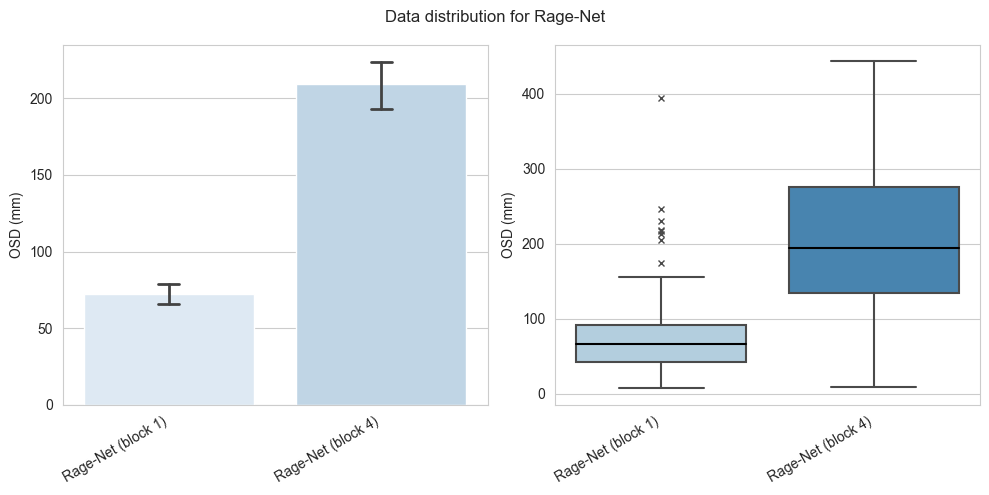

╒════════════════════╤══════════════╤═══════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                   │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 4) │ 4021.0       │ 4.180200576670431e-39 │ -13.029555912694732 │ Reject H0    │   189 │   189 │  0.670168 │
╘════════════════════╧══════════════╧═══════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [28]:
df_subsets = list(itemgetter(0, 2, 3)(column_to_cases(df_with_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 2, 3)(subset_labels))

df_subsets = list(itemgetter(0, 2)(df_subsets))
subset_labels = list(itemgetter(0, 2)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 4 (Camera position: left, Rage-Net with glasses and without glasses)

╒════════════════════╤═════════╤══════════╤═════════╤═════════╤═════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │     Mean │     STD │     Min │     25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪══════════╪═════════╪═════════╪═════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     810 │  56.3163 │ 41.7666 │ 1.06801 │  29.098 │  45.3018 │  72.7244 │ 394.55  │   2.55354  │  11.9186   │
│ Rage-Net (block 4) │     810 │ 211.954  │ 98.4452 │ 8.17915 │ 137.147 │ 226.227  │ 278.162  │ 466.863 │  -0.231001 │  -0.648256 │
╘════════════════════╧═════════╧══════════╧═════════╧═════════╧═════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


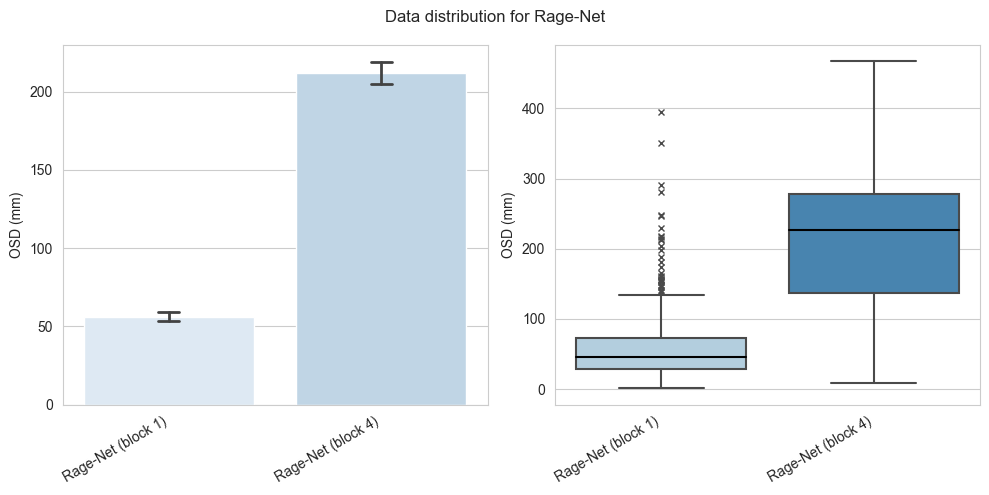

╒════════════════════╤══════════════╤════════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value                │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪════════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                      │ -                   │              │       │       │           │
├────────────────────┼──────────────┼────────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 4) │ 59843.0      │ 7.924056322344294e-179 │ -28.489459186996047 │ Reject H0    │   810 │   810 │  0.707826 │
╘════════════════════╧══════════════╧════════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [29]:
df_subsets = list(itemgetter(0, 2, 3)(column_to_cases(df, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 2, 3)(subset_labels))

df_subsets = list(itemgetter(0, 2)(df_subsets))
subset_labels = list(itemgetter(0, 2)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 5 (Poor lighting, Tobii without glasses)

╒═════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                 │   Count │    Mean │     STD │      Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii (block 1) │     619 │ 11.7178 │ 25.3537 │ 0.265741 │ 4.67925 │ 8.0848  │ 11.6594 │ 292.105 │    8.54037 │    79.6181 │
│ Tobii (block 5) │     607 │ 11.8616 │ 20.7402 │ 0.797222 │ 5.19425 │ 8.28333 │ 13.1516 │ 315.272 │    9.56399 │   111.426  │
╘═════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


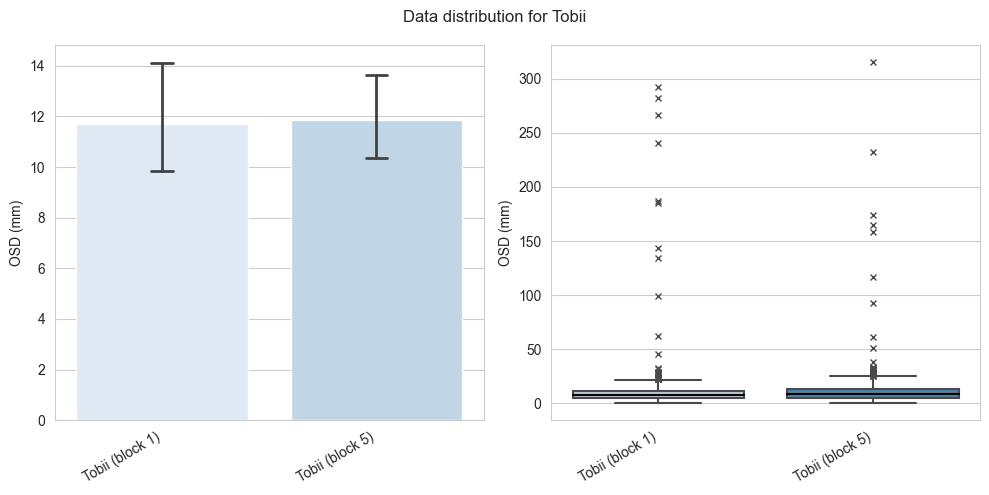

╒═════════════════╤══════════════╤══════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                 │ Statistics   │ P-value              │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════╪══════════════╪══════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii (block 1) │ -            │ -                    │ -                   │              │       │       │           │
├─────────────────┼──────────────┼──────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii (block 5) │ 174991.5     │ 0.018895789301104485 │ -2.0771884990124976 │ Reject H0    │   619 │   607 │  0.059324 │
╘═════════════════╧══════════════╧══════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [30]:
df_subsets = list(itemgetter(0, 4)(column_to_cases(df_no_glasses, 'On_screen_distance_Tobii')))
subset_labels =  [f'Tobii (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 4)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii')
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 5 (Poor lighting, Tobii with glasses)

╒═════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤══════════╤═════════╤═════════╤════════════╤════════════╕
│                 │   Count │    Mean │     STD │      Min │     25% │      50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪══════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii (block 1) │     186 │ 20.9242 │ 43.0807 │ 0.840474 │ 6.17382 │  9.58679 │ 14.3216 │ 253.889 │    3.86459 │    14.6414 │
│ Tobii (block 5) │     180 │ 21.5813 │ 43.7197 │ 0.841499 │ 7.11717 │ 11.465   │ 16.0933 │ 354.673 │    5.09346 │    29.8346 │
╘═════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧══════════╧═════════╧═════════╧════════════╧════════════╛


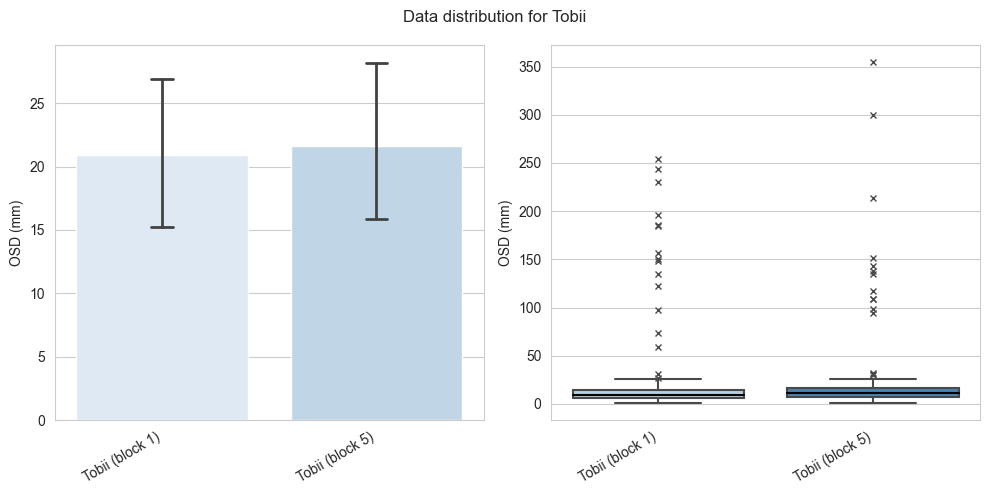

╒═════════════════╤══════════════╤══════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                 │ Statistics   │ P-value              │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════╪══════════════╪══════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii (block 1) │ -            │ -                    │ -                   │              │       │       │           │
├─────────────────┼──────────────┼──────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii (block 5) │ 14377.0      │ 0.009778739851737925 │ -2.3352242282790634 │ Reject H0    │   186 │   180 │  0.122064 │
╘═════════════════╧══════════════╧══════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [31]:
df_subsets = list(itemgetter(0, 4)(column_to_cases(df_with_glasses, 'On_screen_distance_Tobii')))
subset_labels =  [f'Tobii (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 4)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii')
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 5 (Poor lighting, Tobii with glasses and without glasses)

╒═════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                 │   Count │    Mean │     STD │      Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii (block 1) │     805 │ 13.845  │ 30.5979 │ 0.265741 │ 4.90318 │ 8.45119 │ 12.0863 │ 292.105 │    6.40297 │    43.8759 │
│ Tobii (block 5) │     787 │ 14.0846 │ 27.9934 │ 0.797222 │ 5.51789 │ 8.88966 │ 13.9423 │ 354.673 │    7.72786 │    70.9519 │
╘═════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


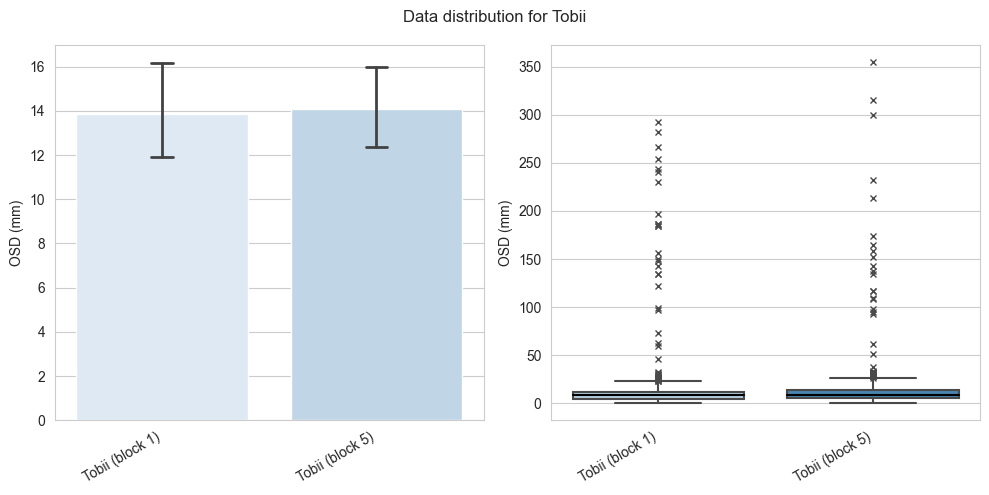

╒═════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                 │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii (block 1) │ -            │ -                     │ -                  │              │       │       │           │
├─────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii (block 5) │ 290143.0     │ 0.0018470969743872377 │ -2.903212929711423 │ Reject H0    │   805 │   787 │ 0.0727625 │
╘═════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [32]:
df_subsets = list(itemgetter(0, 4)(column_to_cases(df, 'On_screen_distance_Tobii')))
subset_labels =  [f'Tobii (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 4)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii')
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 5 (Poor lighting, Rage-Net without glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     621 │ 51.5259 │ 38.1022 │ 1.06801 │ 28.1902 │ 41.2886 │ 67.3515 │ 351.209 │    2.58371 │   12.0349  │
│ Rage-Net (block 5) │     621 │ 59.1132 │ 39.0718 │ 2.70036 │ 30.0085 │ 49.0042 │ 80.1    │ 284.428 │    1.50967 │    3.66351 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


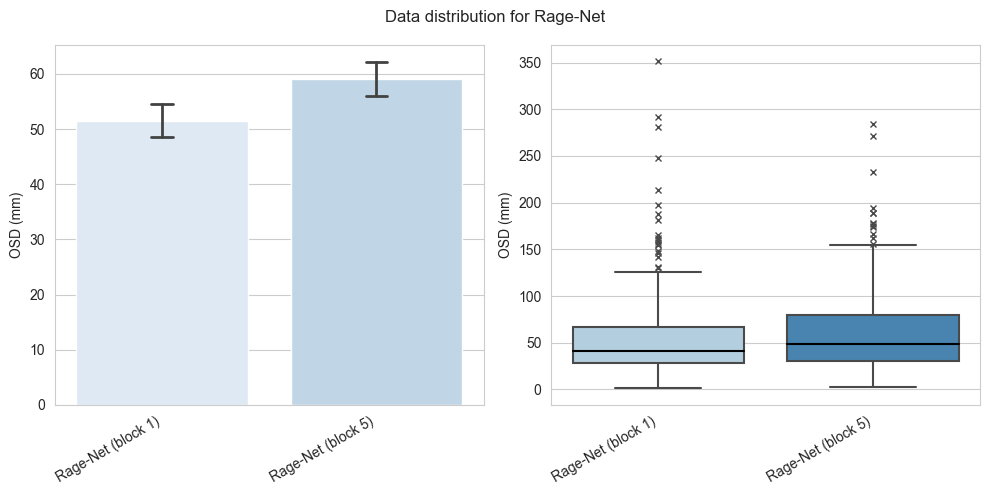

╒════════════════════╤══════════════╤═══════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                   │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 5) │ 168120.0     │ 4.652150655852256e-05 │ -3.9081318126177966 │ Reject H0    │   621 │   621 │  0.110894 │
╘════════════════════╧══════════════╧═══════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [33]:
df_subsets = list(itemgetter(0, 4)(column_to_cases(df_no_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 4)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 5 (Poor lighting, Rage-Net with glasses)

╒════════════════════╤═════════╤═════════╤══════════╤═════════╤═════════╤══════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │      STD │     Min │     25% │      50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪══════════╪═════════╪═════════╪══════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     189 │  72.056 │  48.9292 │ 6.83559 │ 41.7775 │  66.4377 │  91.8954 │ 394.55  │   2.42468  │  10.9102   │
│ Rage-Net (block 5) │     189 │ 153.327 │ 107.254  │ 6.77718 │ 69.832  │ 128.458  │ 198.337  │ 443.785 │   0.978179 │   0.320093 │
╘════════════════════╧═════════╧═════════╧══════════╧═════════╧═════════╧══════════╧══════════╧═════════╧════════════╧════════════╛


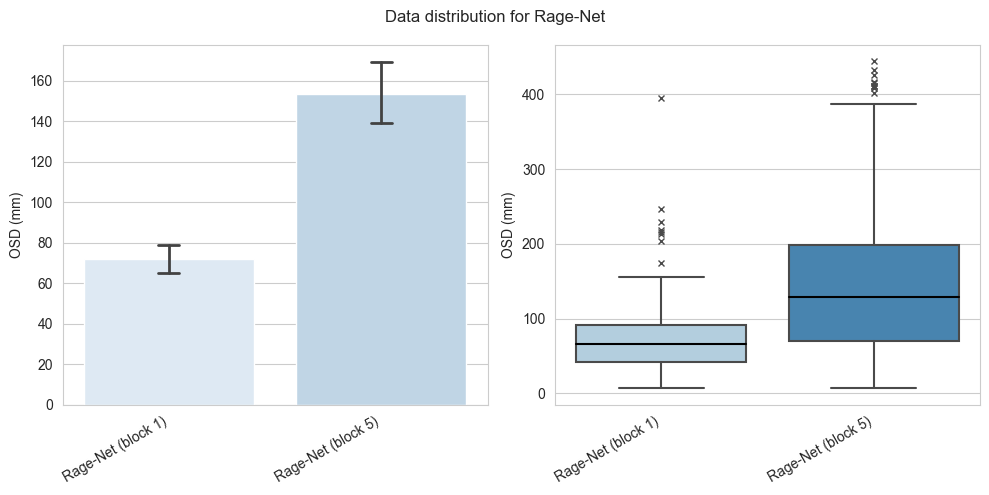

╒════════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                  │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 5) │ 8826.0       │ 9.056845223791607e-18 │ -8.505764145615128 │ Reject H0    │   189 │   189 │  0.437489 │
╘════════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [34]:
df_subsets = list(itemgetter(0, 4)(column_to_cases(df_with_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 4)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 5 (Poor lighting, Rage-Net with glasses and without glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     810 │ 56.3163 │ 41.7666 │ 1.06801 │ 29.098  │ 45.3018 │  72.7244 │ 394.55  │    2.55354 │    11.9186 │
│ Rage-Net (block 5) │     810 │ 81.0965 │ 73.7088 │ 2.70036 │ 33.0275 │ 57.7705 │ 101.646  │ 443.785 │    2.32373 │     6.5413 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════╧═════════╧════════════╧════════════╛


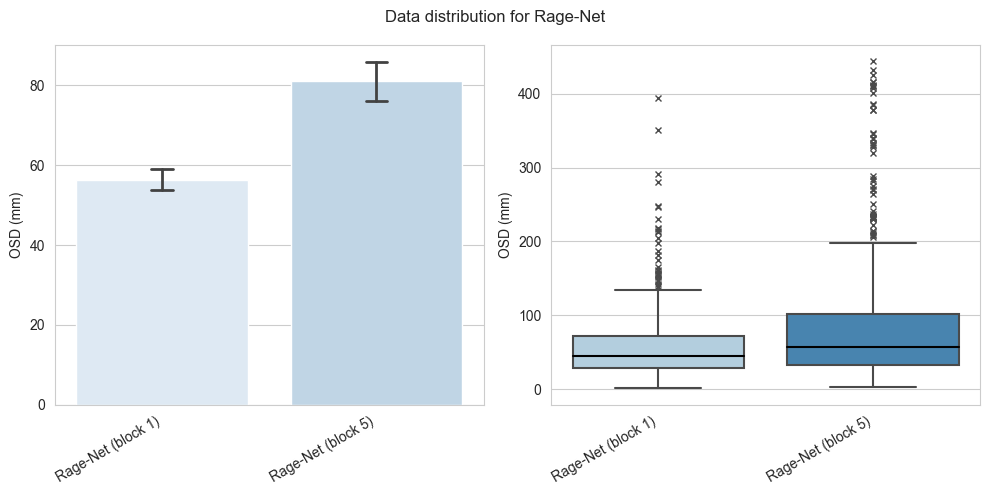

╒════════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                  │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 5) │ 265919.0     │ 2.061061657899325e-11 │ -6.599673344645185 │ Reject H0    │   810 │   810 │   0.16397 │
╘════════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [35]:
df_subsets = list(itemgetter(0, 4)(column_to_cases(df, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 4)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 6 (Strong lighting, Rage-Net without glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     621 │ 51.5259 │ 38.1022 │ 1.06801 │ 28.1902 │ 41.2886 │ 67.3515 │ 351.209 │    2.58371 │   12.0349  │
│ Rage-Net (block 6) │     621 │ 64.3214 │ 36.3887 │ 6.6655  │ 36.7447 │ 55.8884 │ 85.4028 │ 288.174 │    1.39913 │    3.73904 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


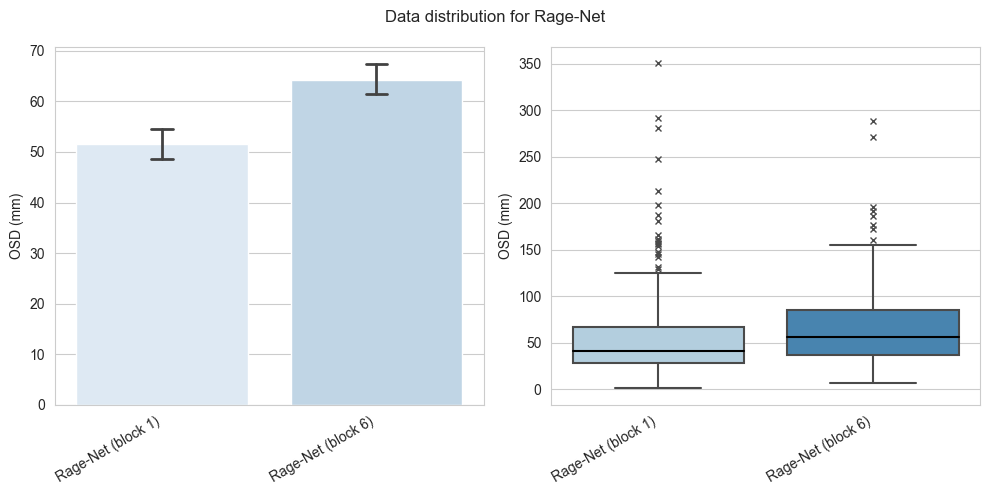

╒════════════════════╤══════════════╤═══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value               │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪═══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                     │ -                  │              │       │       │           │
├────────────────────┼──────────────┼───────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 6) │ 142918.0     │ 1.445394848028593e-15 │ -7.895611334959195 │ Reject H0    │   621 │   621 │   0.22404 │
╘════════════════════╧══════════════╧═══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [36]:
df_subsets = list(itemgetter(0, 5)(column_to_cases(df_no_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 5)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 6 (Strong lighting, Rage-Net with glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │      75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     189 │ 72.056  │ 48.9292 │ 6.83559 │ 41.7775 │ 66.4377 │  91.8954 │ 394.55  │    2.42468 │   10.9102  │
│ Rage-Net (block 6) │     189 │ 80.3052 │ 48.5631 │ 5.25462 │ 45.1229 │ 71.1483 │ 103.414  │ 285.312 │    1.28606 │    2.27172 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════╧═════════╧════════════╧════════════╛


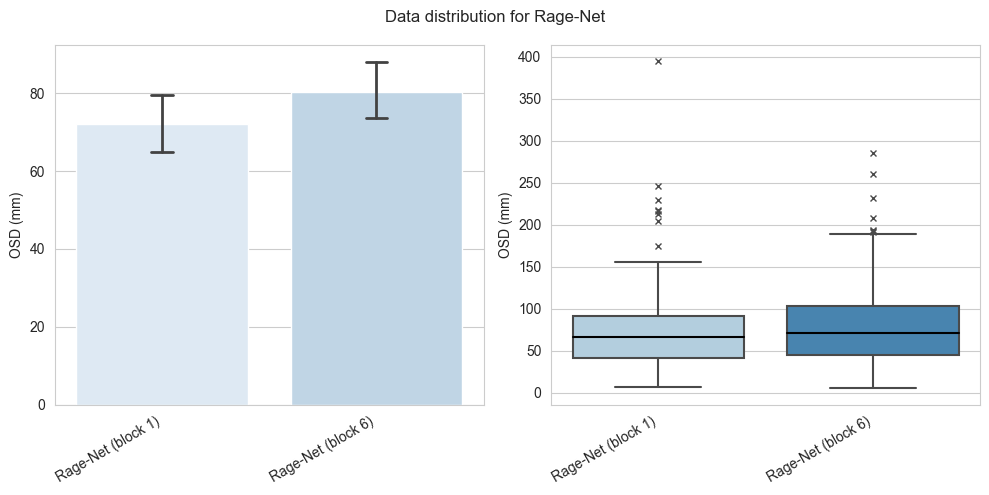

╒════════════════════╤══════════════╤══════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value              │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪══════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                    │ -                  │              │       │       │           │
├────────────────────┼──────────────┼──────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 6) │ 15899.0      │ 0.032429098679003954 │ -1.846705005437387 │ Reject H0    │   189 │   189 │ 0.0949843 │
╘════════════════════╧══════════════╧══════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [37]:
df_subsets = list(itemgetter(0, 5)(column_to_cases(df_with_glasses, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 5)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 6 (Strong lighting, Rage-Net with glasses and without glasses)

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                    │   Count │    Mean │     STD │     Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Rage-Net (block 1) │     810 │ 56.3163 │ 41.7666 │ 1.06801 │ 29.098  │ 45.3018 │ 72.7244 │ 394.55  │    2.55354 │   11.9186  │
│ Rage-Net (block 6) │     810 │ 68.0509 │ 40.1074 │ 5.25462 │ 38.4823 │ 58.9135 │ 91.5594 │ 288.174 │    1.46913 │    3.65569 │
╘════════════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


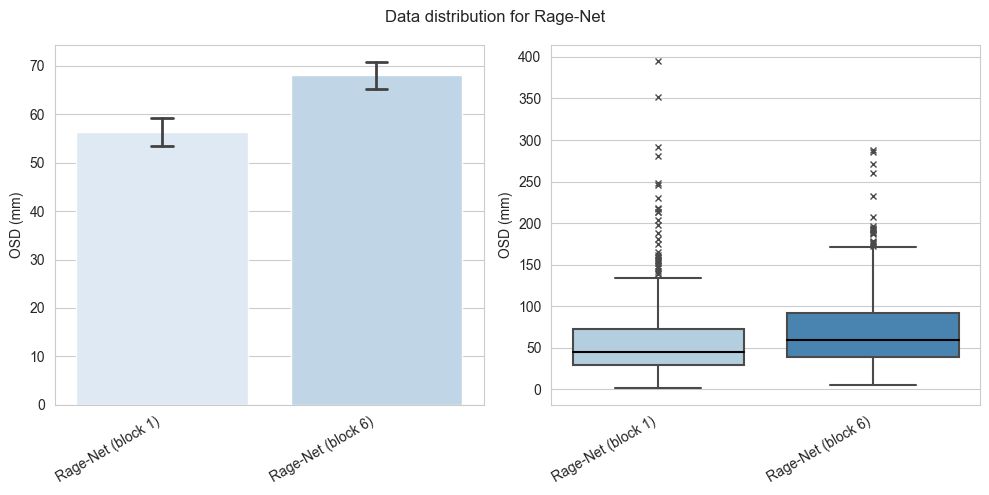

╒════════════════════╤══════════════╤════════════════════════╤════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                    │ Statistics   │ P-value                │ Z-score            │ Hypothesis   │   N_x │   N_y │   R-score │
╞════════════════════╪══════════════╪════════════════════════╪════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Rage-Net (block 1) │ -            │ -                      │ -                  │              │       │       │           │
├────────────────────┼──────────────┼────────────────────────┼────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Rage-Net (block 6) │ 256931.0     │ 2.1049013369776814e-14 │ -7.554395850667476 │ Reject H0    │   810 │   810 │   0.18769 │
╘════════════════════╧══════════════╧════════════════════════╧════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [38]:
df_subsets = list(itemgetter(0, 5)(column_to_cases(df, 'On_screen_distance_Rage-Net')))
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 5)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 6 (Strong lighting, Tobii without glasses)

╒═════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤════════╤═════════╤═════════╤════════════╤════════════╕
│                 │   Count │    Mean │     STD │      Min │     25% │    50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii (block 1) │     619 │ 11.7178 │ 25.3537 │ 0.265741 │ 4.67925 │ 8.0848 │ 11.6594 │ 292.105 │    8.54037 │    79.6181 │
│ Tobii (block 6) │     613 │ 12.0152 │ 18.2651 │ 0.266146 │ 5.72544 │ 9.2161 │ 13.8654 │ 262.304 │    9.11441 │   103.56   │
╘═════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧════════╧═════════╧═════════╧════════════╧════════════╛


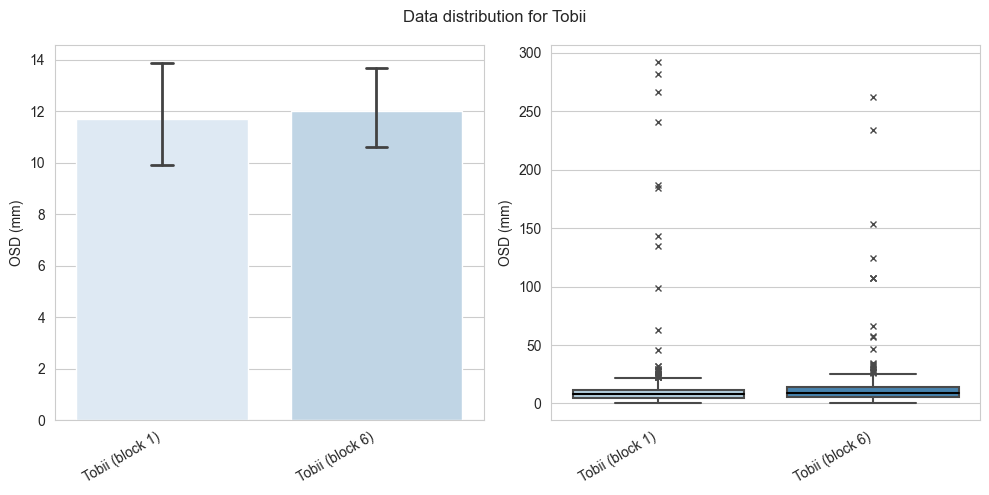

╒═════════════════╤══════════════╤═══════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                 │ Statistics   │ P-value               │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════╪══════════════╪═══════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii (block 1) │ -            │ -                     │ -                   │              │       │       │           │
├─────────────────┼──────────────┼───────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii (block 6) │ 166016.5     │ 7.333116652582013e-05 │ -3.7967335735349153 │ Reject H0    │   619 │   613 │  0.108169 │
╘═════════════════╧══════════════╧═══════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [39]:
df_subsets = list(itemgetter(0, 5)(column_to_cases(df_no_glasses, 'On_screen_distance_Tobii')))
subset_labels =  [f'Tobii (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 5)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii')
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 6 (Strong lighting, Tobii with glasses)

╒═════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤══════════╤═════════╤═════════╤════════════╤════════════╕
│                 │   Count │    Mean │     STD │      Min │     25% │      50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪══════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii (block 1) │     186 │ 20.9242 │ 43.0807 │ 0.840474 │ 6.17382 │  9.58679 │ 14.3216 │ 253.889 │    3.86459 │    14.6414 │
│ Tobii (block 6) │     182 │ 16.0195 │ 28.7951 │ 0.532292 │ 5.99954 │ 10.1436  │ 14.6639 │ 199.208 │    5.19674 │    27.8358 │
╘═════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧══════════╧═════════╧═════════╧════════════╧════════════╛


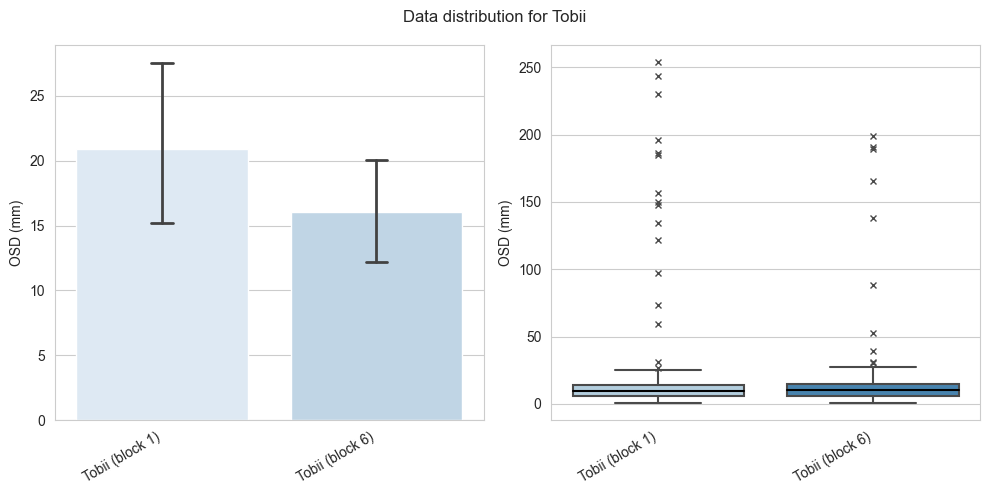

╒═════════════════╤══════════════╤════════════════════╤═════════════════════╤═══════════════════╤═══════╤═══════╤═══════════╕
│                 │ Statistics   │ P-value            │ Z-score             │ Hypothesis        │   N_x │   N_y │   R-score │
╞═════════════════╪══════════════╪════════════════════╪═════════════════════╪═══════════════════╪═══════╪═══════╪═══════════╡
│ Tobii (block 1) │ -            │ -                  │ -                   │                   │       │       │           │
├─────────────────┼──────────────┼────────────────────┼─────────────────────┼───────────────────┼───────┼───────┼───────────┤
│ Tobii (block 6) │ 16331.5      │ 0.2802160981825431 │ -0.5826894202700976 │ Fail to reject H0 │   186 │   182 │ 0.0303748 │
╘═════════════════╧══════════════╧════════════════════╧═════════════════════╧═══════════════════╧═══════╧═══════╧═══════════╛


In [40]:
df_subsets = list(itemgetter(0, 5)(column_to_cases(df_with_glasses, 'On_screen_distance_Tobii')))
subset_labels =  [f'Tobii (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 5)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii')
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Hypothesis 6 (Strong lighting, Tobii with glasses and without glasses)

╒═════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤═════════╤═════════╤════════════╤════════════╕
│                 │   Count │    Mean │     STD │      Min │     25% │     50% │     75% │     Max │   Skewness │   Curtosis │
╞═════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════╪═════════╪═════════╪════════════╪════════════╡
│ Tobii (block 1) │     805 │ 13.845  │ 30.5979 │ 0.265741 │ 4.90318 │ 8.45119 │ 12.0863 │ 292.105 │    6.40297 │    43.8759 │
│ Tobii (block 6) │     795 │ 12.9319 │ 21.1894 │ 0.266146 │ 5.80453 │ 9.40333 │ 14.1204 │ 262.304 │    7.55449 │    66.649  │
╘═════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧═════════╧═════════╧═════════╧════════════╧════════════╛


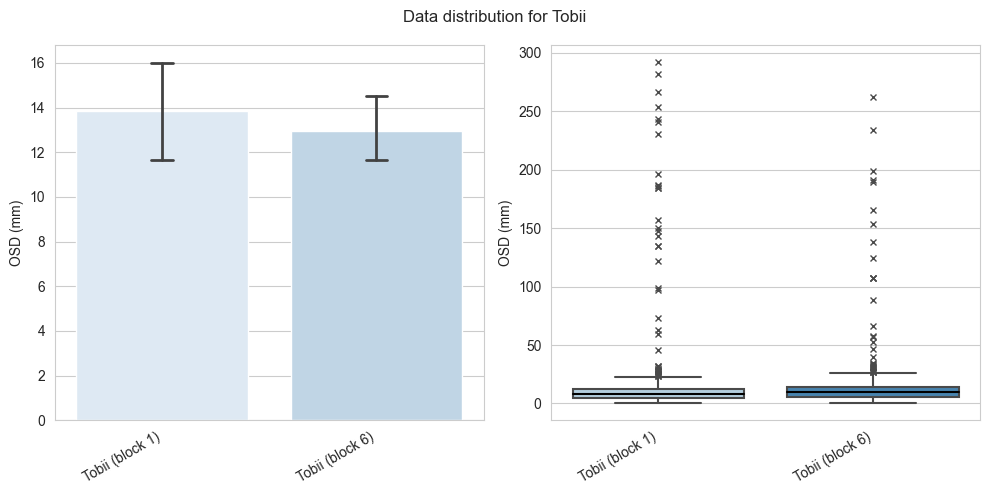

╒═════════════════╤══════════════╤════════════════════════╤═════════════════════╤══════════════╤═══════╤═══════╤═══════════╕
│                 │ Statistics   │ P-value                │ Z-score             │ Hypothesis   │   N_x │   N_y │   R-score │
╞═════════════════╪══════════════╪════════════════════════╪═════════════════════╪══════════════╪═══════╪═══════╪═══════════╡
│ Tobii (block 1) │ -            │ -                      │ -                   │              │       │       │           │
├─────────────────┼──────────────┼────────────────────────┼─────────────────────┼──────────────┼───────┼───────┼───────────┤
│ Tobii (block 6) │ 286560.5     │ 0.00014875100106299225 │ -3.6175192757853347 │ Reject H0    │   805 │   795 │  0.090438 │
╘═════════════════╧══════════════╧════════════════════════╧═════════════════════╧══════════════╧═══════╧═══════╧═══════════╛


In [41]:
df_subsets = list(itemgetter(0, 5)(column_to_cases(df, 'On_screen_distance_Tobii')))
subset_labels =  [f'Tobii (block {index + 1})' for index in range(6)]
subset_labels = list(itemgetter(0, 5)(subset_labels))

describe_data(df_subsets, subset_labels)
plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Tobii')
mann_whitney_u_test(df_subsets, subset_labels, 0.05, alternative='less')

## Visualiztions

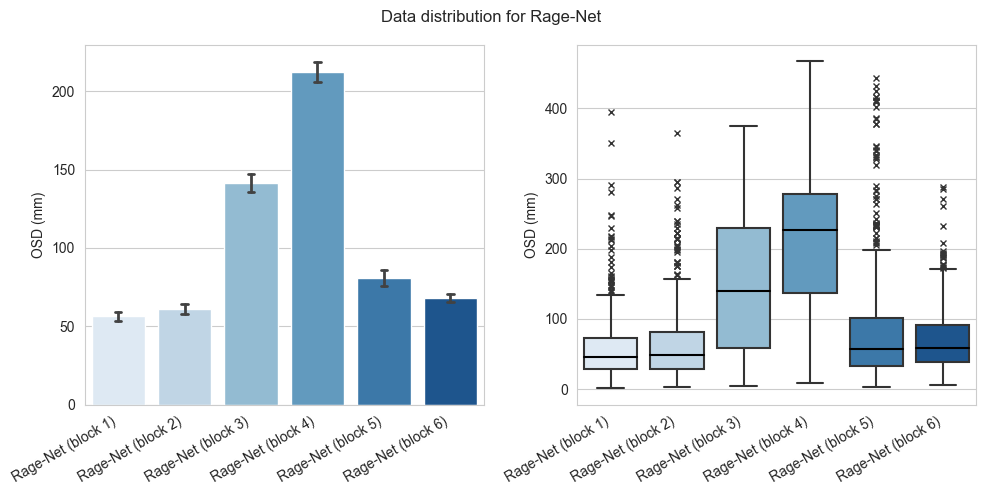

In [42]:
df_subsets = column_to_cases(df, 'On_screen_distance_Rage-Net')
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]

plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

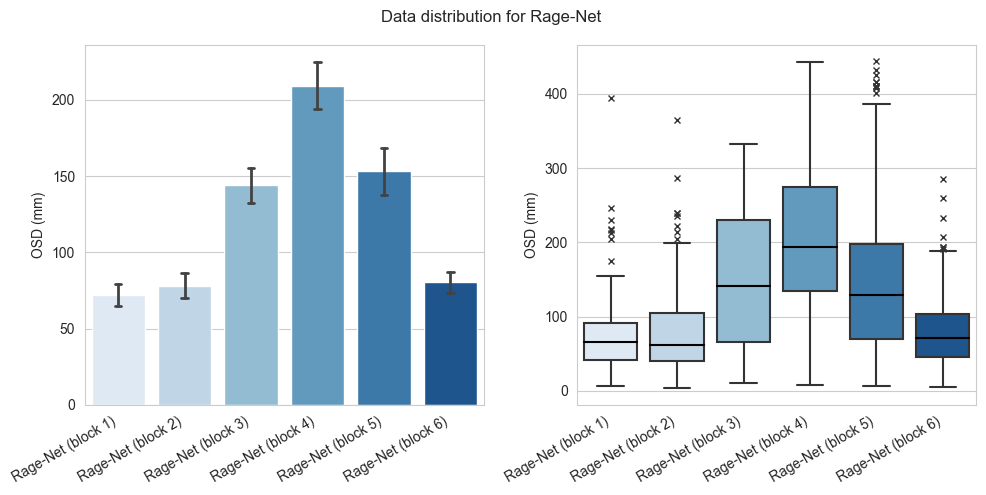

In [43]:
df_subsets = column_to_cases(df_with_glasses, 'On_screen_distance_Rage-Net')
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]

plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')

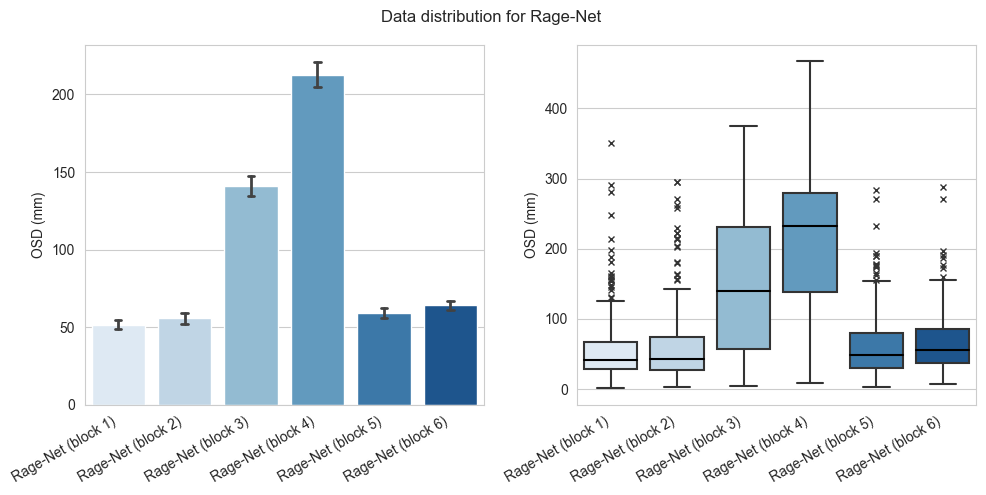

In [44]:
df_subsets = column_to_cases(df_no_glasses, 'On_screen_distance_Rage-Net')
subset_labels =  [f'Rage-Net (block {index + 1})' for index in range(6)]

plot_central_tendecies_hypothesis_combined(df_subsets, subset_labels, 'Data distribution for Rage-Net')